### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction import stop_words
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.style.use('bmh')

### Reading in CSVs

In [2]:
# Save the list of files to a variable
file_list = os.listdir('../data/scrapes/')
csvs = []
# Loop through list to read in the files as a data frame

for i in file_list:
    # create file link
    if "." not in i[0]:
        path = "../data/scrapes/" + i
    
        # using created link read in csv file and save to list
        csv = pd.read_csv(path)
        csvs.append(csv)
        
# concatenate each file read
print(f'The number of DataFrames loaded is: {len(csvs)}')
df = pd.concat(csvs, axis=0)
print(f'The size of merged DataFrame is: {df.shape}')

# remove duplicate rows
df = df.drop_duplicates()

# Resetting index
df = df.reset_index(drop=True)
print(f'The size of reduced DataFrame is: {df.shape}')

The number of DataFrames loaded is: 12
The size of merged DataFrame is: (11850, 7)
The size of reduced DataFrame is: (11850, 7)


In [3]:
df.head()

,title,body,num_comments,upvote_ratio,url,elapsed_time,subreddit
0,"Week 6 Overperformers: Robby Anderson, Hunter ...",NaN,36,0.78,https://www.thefantasyfootballadvice.com/artic...,113.369934,r/fantasyfootball
1,Fantasy Football Week 7: Starts & Sits,NaN,8,0.88,https://www.youtube.com/watch?v=bBNYQpk4ziQ,129.536600,r/fantasyfootball
2,2019 Accuracy Challenge Week 7,#####Accuracy Challenge Week 7\n\n\n######How ...,0,0.67,https://www.reddit.com/r/fantasyfootball/comme...,137.136600,r/fantasyfootball
3,"Based on the first 6 weeks, what does the firs...",Says me:\n\n1. CMC\n2. Dalvin\n3. Saquon\n4. C...,112,0.52,https://www.reddit.com/r/fantasyfootball/comme...,235.953267,r/fantasyfootball
4,Joe Mixon has run 20 pass routes over the last...,NaN,52,0.88,https://twitter.com/GrahamBarfield/status/1184...,251.553267,r/fantasyfootball


#### Removing rows that contain official

In [4]:
omit_mask = df['title'].str.contains('Official:')

* Noticed that there are reoccuring posts (bot threads) in the Fantasy Football Reddit that has "Official:" in the title.
* These post watered down my text with meaningless words and text that wasn't relevant to analyzing football talk. 
* So I decided to delete rows that contains this text.

In [5]:
print(f'There will be {len(df[omit_mask])} rows removed.')

There will be 1031 rows removed.


In [6]:
df = df[~omit_mask]

In [7]:
df.shape

(10819, 7)

In [8]:
df['body'].isnull().sum()

6486

In [9]:
df['body'].fillna("", inplace=True)

In [10]:
df['body'].isnull().sum()

0

In [11]:
df['title'].isnull().sum()

0

In [12]:
df['url_website'] = df['url'].apply(lambda x: x.split("/")[2].split(".")[-2])

In [13]:
df['url_website'].value_counts(normalize=True).head(10)

reddit                    0.428228
twitter                   0.400961
streamable                0.017192
youtube                   0.015343
youtu                     0.013587
nbcsports                 0.013217
clippituser               0.013217
espn                      0.008688
usatoday                  0.005546
pro-football-reference    0.004437
Name: url_website, dtype: float64

In [14]:
# Condensing Website to the 4 majority and bucketing the rest to other, because they have a smaller portion of the DataFrame designation.
df['url_website'] = df['url_website'].map(lambda site: 'Reddit' if site == 'reddit' else ('Twitter' if site == 'twitter' else ('YouTube' if site == 'youtube' else ('YouTube' if site == 'youtu' else 'Other'))))

In [15]:
df['url_website'].value_counts(normalize=True)

Reddit     0.428228
Twitter    0.400961
Other      0.141880
YouTube    0.028931
Name: url_website, dtype: float64

In [16]:
df['all_text'] = df['title'] + df['body']

In [17]:
# Binorizing body column on whether or not it has text in the body and creating a new column
df['text_in_body'] = [0 if item == "" else 1 for item in df['body']]

Creating word count & character count columns

In [18]:
df['word_count'] = df['all_text'].apply(lambda x: len(x.split()))

In [19]:
df['char_count'] = df['all_text'].apply(len)

In [20]:
df['subreddit'].value_counts()

r/nfl                5867
r/fantasyfootball    4952
Name: subreddit, dtype: int64

In [180]:
df['subreddit'].value_counts(normalize=True)

r/nfl                0.542287
r/fantasyfootball    0.457713
Name: subreddit, dtype: float64

In [21]:
# Binorizing subreddit type and creating a target column
df['pred_target'] = [1 if item == 'r/fantasyfootball' else 0 for item in df['subreddit']]

In [22]:
df.shape

(10819, 13)

In [23]:
df.head()

,title,body,num_comments,upvote_ratio,url,elapsed_time,subreddit,url_website,all_text,text_in_body,word_count,char_count,pred_target
0,"Week 6 Overperformers: Robby Anderson, Hunter ...",,36,0.78,https://www.thefantasyfootballadvice.com/artic...,113.369934,r/fantasyfootball,Other,"Week 6 Overperformers: Robby Anderson, Hunter ...",0,9,61,1
1,Fantasy Football Week 7: Starts & Sits,,8,0.88,https://www.youtube.com/watch?v=bBNYQpk4ziQ,129.536600,r/fantasyfootball,YouTube,Fantasy Football Week 7: Starts & Sits,0,7,38,1
2,2019 Accuracy Challenge Week 7,#####Accuracy Challenge Week 7\n\n\n######How ...,0,0.67,https://www.reddit.com/r/fantasyfootball/comme...,137.136600,r/fantasyfootball,Reddit,2019 Accuracy Challenge Week 7#####Accuracy Ch...,1,735,4736,1
3,"Based on the first 6 weeks, what does the firs...",Says me:\n\n1. CMC\n2. Dalvin\n3. Saquon\n4. C...,112,0.52,https://www.reddit.com/r/fantasyfootball/comme...,235.953267,r/fantasyfootball,Reddit,"Based on the first 6 weeks, what does the firs...",1,39,183,1
4,Joe Mixon has run 20 pass routes over the last...,,52,0.88,https://twitter.com/GrahamBarfield/status/1184...,251.553267,r/fantasyfootball,Twitter,Joe Mixon has run 20 pass routes over the last...,0,31,167,1


### Analysis/EDA

### Sentiment Analysis

In [24]:
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [25]:
# Write a function to get the compound sentiment scores for a post
def sent_compound(text):
    return sia.polarity_scores(text)['compound']

In [26]:
# apply the function to the entire df
df['sentiment'] = df['all_text'].apply(sent_compound)

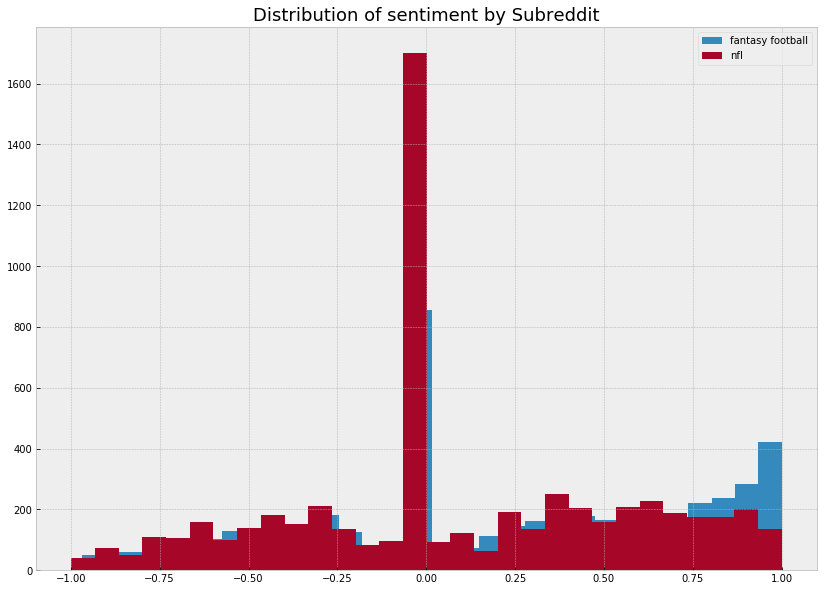

In [149]:
plt.figure(figsize=(14,10))
df.groupby('subreddit')['sentiment'].hist(bins=30);
plt.title("Distribution of sentiment by Subreddit", fontsize = 18);
plt.legend(['fantasy football', 'nfl']);

Text(0.5, 1.0, 'Boxplot of sentiment by Subreddit')

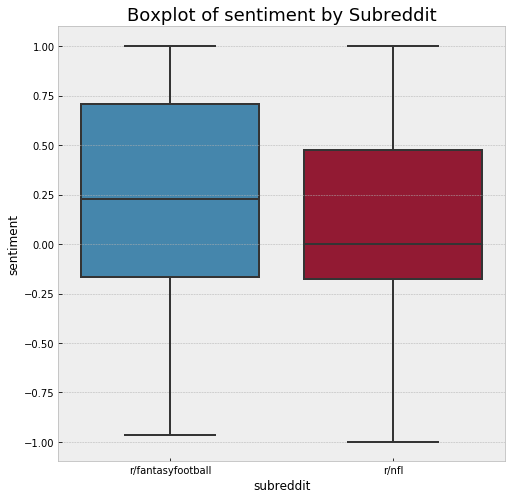

In [152]:
# Boxplot of Sentiment
plt.figure(figsize=(8,8))
sns.plotting_context(context=None, font_scale=1.5)
sns.boxplot(x=df["subreddit"], y=df["sentiment"])
plt.title("Boxplot of sentiment by Subreddit", fontsize = 18);

In [41]:
X = df['all_text']
y = df['pred_target']

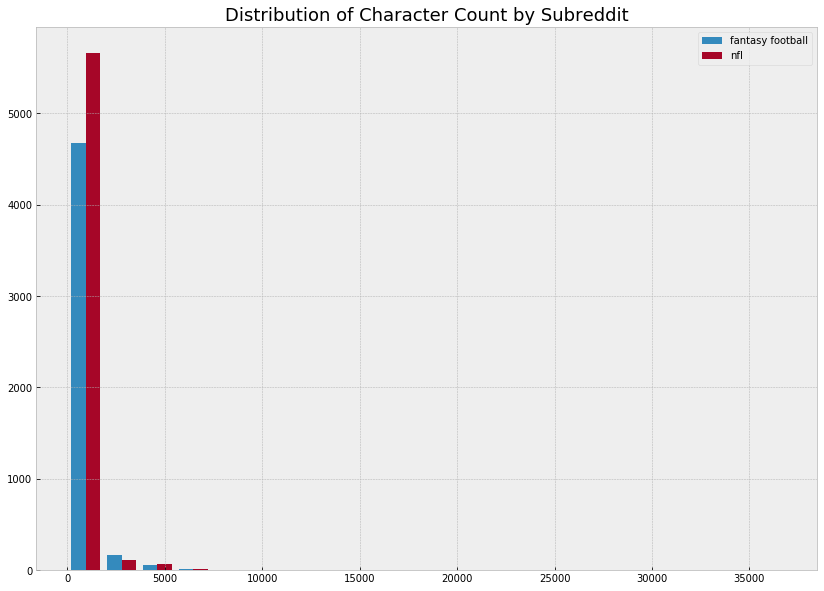

In [178]:
# Histogram of Character Count
mask = (df['pred_target'] == 1)
plt.figure(figsize=(14,10))
plt.hist([df[mask]['char_count'], df[~mask]['char_count']],
         bins = 20);

plt.legend(['fantasy football', 'nfl']);
plt.title("Distribution of Character Count by Subreddit", fontsize = 18);

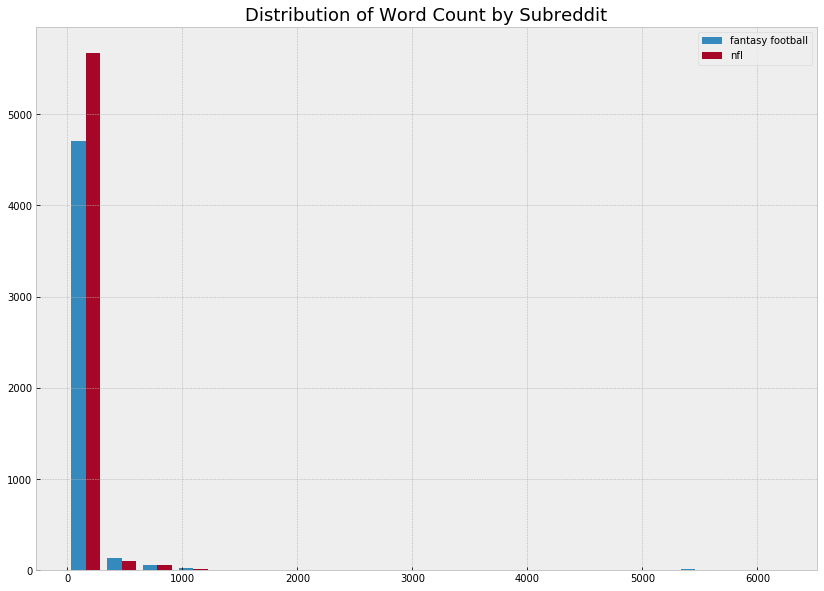

In [174]:
# histogram of word counts
plt.figure(figsize=(14,10))
plt.hist([df[mask]['word_count'], df[~mask]['word_count']],
         bins = 20);

plt.legend(['fantasy football', 'nfl']);
plt.title("Distribution of Word Count by Subreddit", fontsize = 18);

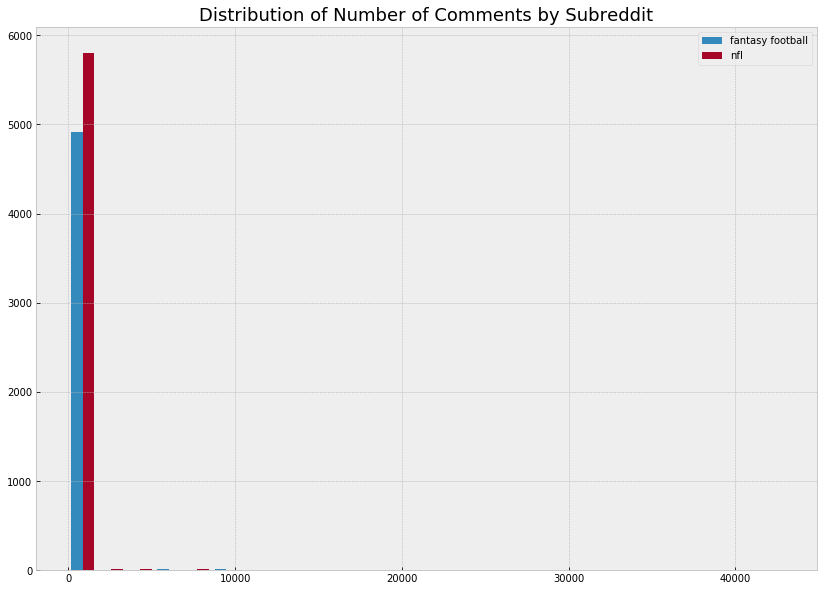

In [175]:
# Draw a histogram of number of comments
plt.figure(figsize=(14,10))
plt.hist([df[mask]['num_comments'], df[~mask]['num_comments']],
         bins = 25);

plt.legend(['fantasy football', 'nfl']);
plt.title("Distribution of Number of Comments by Subreddit", fontsize = 18);

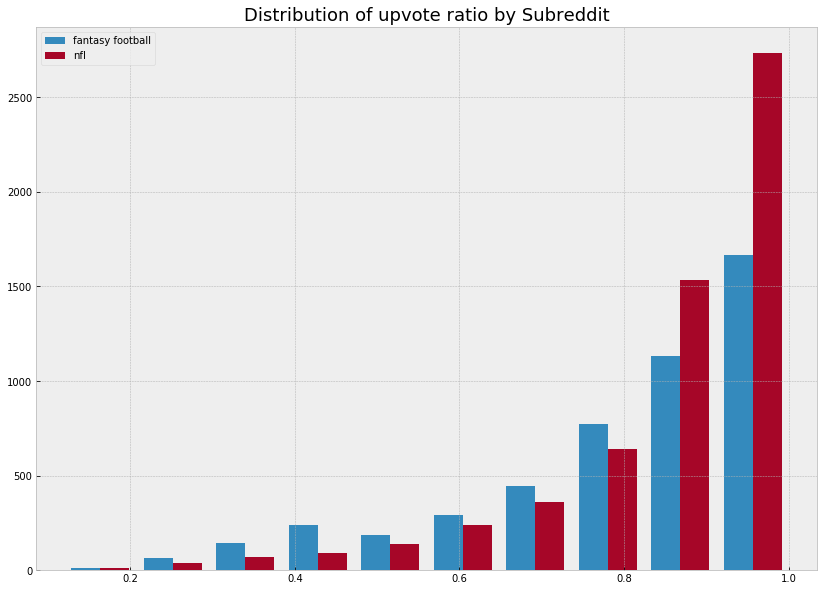

In [158]:
# Draw a histogram of upvote ratio
plt.figure(figsize=(14,10))
plt.hist([df[mask]['upvote_ratio'],df[~mask]['upvote_ratio']]);

plt.legend(['fantasy football', 'nfl']);
plt.title("Distribution of upvote ratio by Subreddit", fontsize = 18);

In [46]:
df['pred_target'].value_counts(normalize=True)

0    0.542287
1    0.457713
Name: pred_target, dtype: float64

In [47]:
df['text_in_body'].value_counts()

0    6486
1    4333
Name: text_in_body, dtype: int64

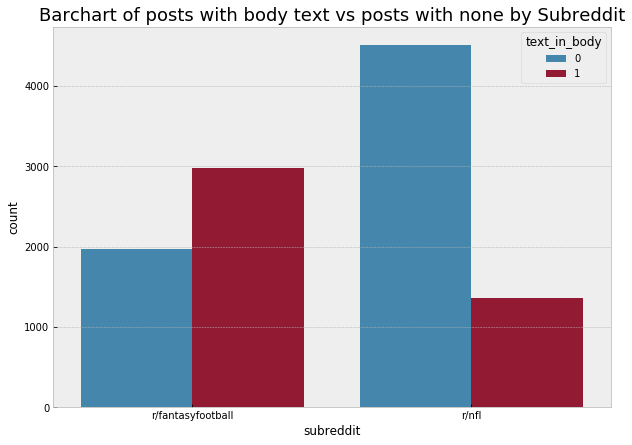

In [159]:
plt.figure(figsize=(10,7))
sns.countplot(x="subreddit", hue="text_in_body", data=df)
plt.title("Barchart of posts with body text vs posts with none by Subreddit", fontsize = 18);

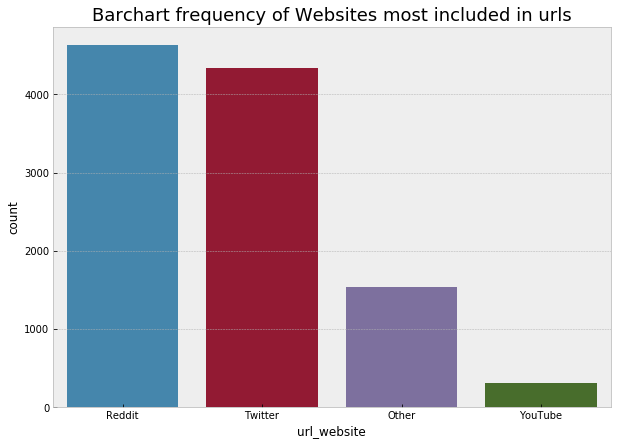

In [161]:
# web_plot = df[df["url_website"] > 10]
plt.figure(figsize=(10,7))
sns.countplot(x="url_website", data=df, order=['Reddit','Twitter','Other','YouTube']);
plt.title("Barchart frequency of Websites most included in urls", fontsize = 18);

### Stop Words

In [50]:
custom_stop = list(ENGLISH_STOP_WORDS)
reddit_omit = ['comments','comment','https','fantasyfootball','help','thread','questions','league',
               'com','helped','following','users','threads','user','table','wdis','week','people','www','reddit','fantasy']
custom_stop.extend(reddit_omit)

In [51]:
custom_stop

['still',
 'same',
 'whom',
 'its',
 'serious',
 'back',
 'fire',
 'because',
 'much',
 'me',
 'besides',
 'upon',
 'put',
 'never',
 'what',
 'must',
 'anywhere',
 'front',
 'here',
 'thick',
 'now',
 'or',
 'again',
 'were',
 'hence',
 'of',
 'first',
 'hers',
 'i',
 'becomes',
 'more',
 'beside',
 'do',
 'twelve',
 'had',
 'eleven',
 'found',
 'together',
 'from',
 'can',
 'themselves',
 'throughout',
 'along',
 'would',
 'such',
 'thus',
 'part',
 'any',
 'hundred',
 'there',
 'four',
 'seems',
 'thence',
 'per',
 'show',
 'amount',
 'anything',
 'become',
 'namely',
 'either',
 'few',
 'eg',
 'her',
 'thereupon',
 'under',
 'each',
 'if',
 'my',
 'through',
 'became',
 'bill',
 'above',
 'before',
 'already',
 'over',
 'de',
 'former',
 'the',
 'between',
 'via',
 'might',
 'himself',
 'among',
 'anyway',
 'well',
 'describe',
 'move',
 'fifteen',
 'empty',
 'name',
 'been',
 'rather',
 'cannot',
 'latter',
 'always',
 'couldnt',
 'latterly',
 'beforehand',
 'who',
 'somehow',
 'f

* I am including stop words that is very heavy to one side of one reddit or another. Also excluding obvious words (e.g. fantasyfootball)

## Vectorizer Transformations

### Count Vectorizer

### Unigram

In [52]:
# Initialize the CountVectorizer
cvec = CountVectorizer(stop_words=custom_stop, max_df = 0.90, min_df=1, ngram_range=(1,1))

In [53]:
word_matrix = cvec.fit_transform(df['all_text'])

In [54]:
# This is the number of unique words, exluding the limitations we initially put in
len(cvec.get_feature_names())

13970

In [55]:
word_df = pd.DataFrame(
        word_matrix.toarray(), columns=cvec.get_feature_names())

word_df.head()

,00,000,000ft,001,003,006,007,01,011,012,...,zkclcdt2qoa,znmyb6q,zone,zoned,zoo,zoolander,zoom,zrebiec,zuerlein,ಠ_ಠ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
word_df['pred_target'] = y

In [57]:
word_df.head()

,00,000,000ft,001,003,006,007,01,011,012,...,znmyb6q,zone,zoned,zoo,zoolander,zoom,zrebiec,zuerlein,ಠ_ಠ,pred_target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [58]:
# Let's use dictionary comprehension to create a dictionary of summed words
freq_dict = {word: word_df[word].sum() for word in cvec.get_feature_names()}

In [59]:
# Create a dataframe with index = 'counts'
freq_df = pd.DataFrame(freq_dict, index=['counts'])

# Transpose the dataframe
freq_df = freq_df.T

In [60]:
# Look at the head of the dataframe
freq_df.sort_values(by='counts', ascending=False).head()

,counts
game,4598
season,3669
nfl,3615
yards,3496
team,2684


In [61]:
top_20 = list(freq_df.sort_values(by='counts', ascending=False).head(20).index)

['game',
 'season',
 'nfl',
 'yards',
 'team',
 '10',
 'games',
 'good',
 'just',
 'play',
 'wr',
 'like',
 'year',
 'qb',
 '12',
 'points',
 'defense',
 '11',
 'td',
 'vs']

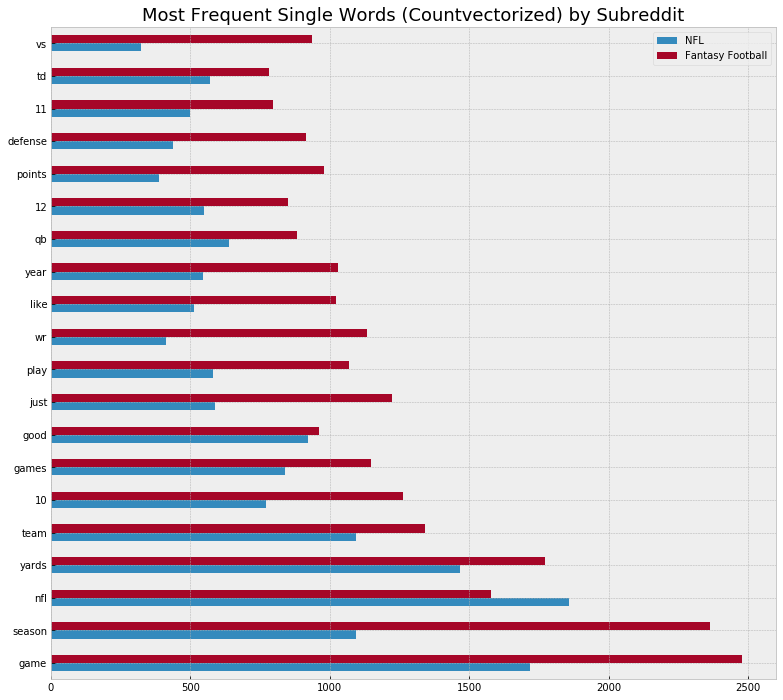

In [165]:
# Count Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
word_df.groupby('pred_target').sum()[top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Single Words (Countvectorized) by Subreddit", fontsize = 18);

### Bigram

In [63]:
# Initialize the CountVectorizer
bi_cvec = CountVectorizer(stop_words=custom_stop, max_df = 0.90, min_df=1, ngram_range=(2,2))

In [64]:
bi_word_matrix = bi_cvec.fit_transform(df['all_text'])

In [65]:
# This is the number of bigram words, exluding the limitations we initially put in
len(bi_cvec.get_feature_names())

108597

In [66]:
bi_word_df = pd.DataFrame(
        bi_word_matrix.toarray(), columns=bi_cvec.get_feature_names())

bi_word_df.head()

,00 00,00 13,00 50,00 57,00 75,00 86,00 atl,00 bonus,00 bye,00 dst,...,zuerlein 10,zuerlein 30,zuerlein josh,zuerlein kick,zuerlein kicker,zuerlein major,zuerlein obvs,zuerlein owners,zuerlein rams,zuerlein stat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
bi_word_df['pred_target'] = y

In [68]:
# Let's use dictionary comprehension to create a dictionary of summed words
bfreq_dict = {word: bi_word_df[word].sum() for word in bi_cvec.get_feature_names()}

In [69]:
# Create a dataframe with index = 'counts'
bfreq_df = pd.DataFrame(bfreq_dict, index=['counts'])

# Transpose the dataframe
bfreq_df = bfreq_df.T

In [70]:
# Look at the head of the dataframe
bfreq_df.sort_values(by='counts', ascending=False).head()

,counts
target share,459
drive plays,411
field goal,351
kick good,342
good drive,322


In [71]:
bi_top_20 = list(bfreq_df.sort_values(by='counts', ascending=False).head(20).index)

['target share',
 'drive plays',
 'field goal',
 'kick good',
 'good drive',
 '5b 5d',
 'injuries watch',
 'goal drive',
 'yd field',
 'auto refresh',
 'rz looks',
 '91 highlight',
 'highlight 93',
 'yards td',
 'rushing yards',
 'ppg allowed',
 'draft_pos 5b',
 'ppg season',
 'baker mayfield',
 'red zone']

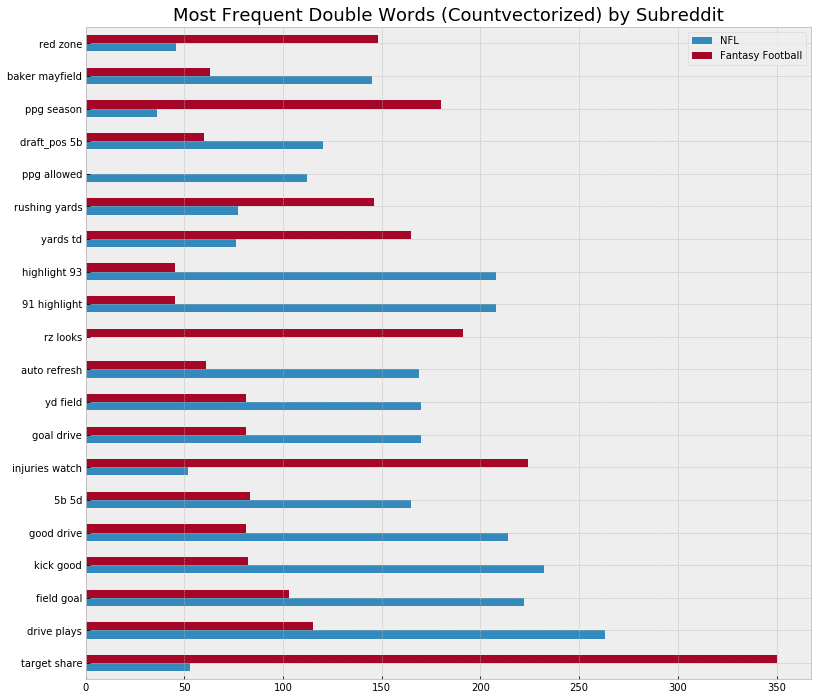

In [166]:
# Count Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
bi_word_df.groupby('pred_target').sum()[bi_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Double Words (Countvectorized) by Subreddit", fontsize = 18);

### Trigram

In [73]:
# Initialize the CountVectorizer
tri_cvec = CountVectorizer(stop_words=custom_stop, max_df = 0.90, min_df=1, ngram_range=(3,3))

In [74]:
tri_word_matrix = tri_cvec.fit_transform(df['all_text'])

In [75]:
# This is the number of bigram words, exluding the limitations we initially put in
len(tri_cvec.get_feature_names())

134945

In [76]:
tri_word_df = pd.DataFrame(
        tri_word_matrix.toarray(), columns=tri_cvec.get_feature_names())

tri_word_df.head()

,00 00 throw,00 13 54,00 50 50,00 57 29,00 75 75,00 86 18,00 atl falcons,00 bonus twigs,00 bye 25,00 dst new,...,zuerlein 10 rams,zuerlein 30 yard,zuerlein josh lambo,zuerlein kick good,zuerlein kicker matter,zuerlein major outlier,zuerlein obvs hit,zuerlein owners feel,zuerlein rams falcons,zuerlein stat correction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
tri_word_df['pred_target'] = y

In [78]:
# Let's use dictionary comprehension to create a dictionary of summed words
tfreq_dict = {word: tri_word_df[word].sum() for word in tri_cvec.get_feature_names()}

In [79]:
# Create a dataframe with index = 'counts'
tfreq_df = pd.DataFrame(tfreq_dict, index=['counts'])

# Transpose the dataframe
tfreq_df = tfreq_df.T

In [80]:
# Look at the head of the dataframe
tfreq_df.sort_values(by='counts', ascending=False).head()

,counts
kick good drive,322
field goal drive,274
yd field goal,274
91 highlight 93,253
draft_pos 5b 5d,220


In [81]:
tri_top_20 = list(tfreq_df.sort_values(by='counts', ascending=False).head(20).index)

['kick good drive',
 'field goal drive',
 'yd field goal',
 '91 highlight 93',
 'draft_pos 5b 5d',
 'good drive plays',
 'yds lng tds',
 'tab auto refresh',
 'goal drive plays',
 'wr cb matchups',
 'pro football reference',
 'key wr cb',
 'qb wr te',
 'target share season',
 'rb snap touches',
 'injuries watch def',
 'relevant target share',
 'snap touches targets',
 'wr te breakdown',
 'rb target share']

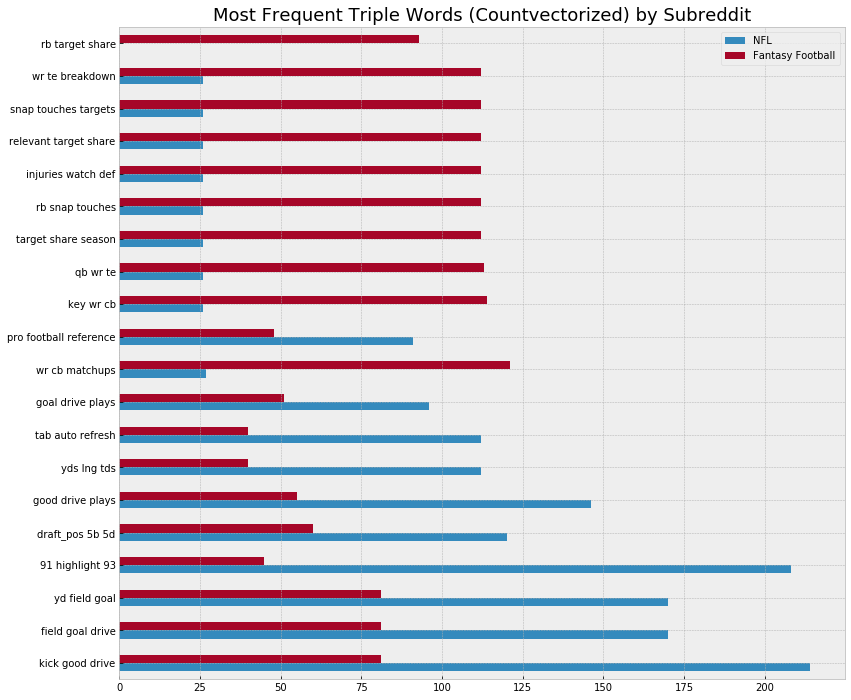

In [167]:
# Count Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
tri_word_df.groupby('pred_target').sum()[tri_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Triple Words (Countvectorized) by Subreddit", fontsize = 18);

### TFIDF Vectorizer

### Unigram

In [83]:
# Fit the transformer.
tvec = TfidfVectorizer(stop_words=custom_stop, max_df = 0.90, min_df=1, ngram_range=(1,1))

In [84]:
tfidf_df = pd.DataFrame(tvec.fit_transform(df['all_text']).toarray(),
                  columns=tvec.get_feature_names())
tfidf_df.head()

,00,000,000ft,001,003,006,007,01,011,012,...,zkclcdt2qoa,znmyb6q,zone,zoned,zoo,zoolander,zoom,zrebiec,zuerlein,ಠ_ಠ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
tfidf_df['pred_target'] = y

In [86]:
# Let's use dictionary comprehension to create a dictionary of summed words
freq_dict2 = {word: tfidf_df[word].sum() for word in tvec.get_feature_names()}

In [87]:
# Create a dataframe with index = 'counts'
freq_df2 = pd.DataFrame(freq_dict2, index=['counts'])

# Transpose the dataframe
freq_df2 = freq_df2.T

In [88]:
tfidf_df

,00,000,000ft,001,003,006,007,01,011,012,...,znmyb6q,zone,zoned,zoo,zoolander,zoom,zrebiec,zuerlein,ಠ_ಠ,pred_target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Look at the head of the dataframe
tf_top_20 = list(freq_df2.sort_values(by='counts', ascending=False).head(20).index)

['game',
 'nfl',
 'yards',
 'season',
 'team',
 'games',
 'play',
 'just',
 'like',
 'good',
 'today',
 'qb',
 'highlight',
 'wr',
 'injury',
 'year',
 'practice',
 'time',
 'teams',
 'vs']

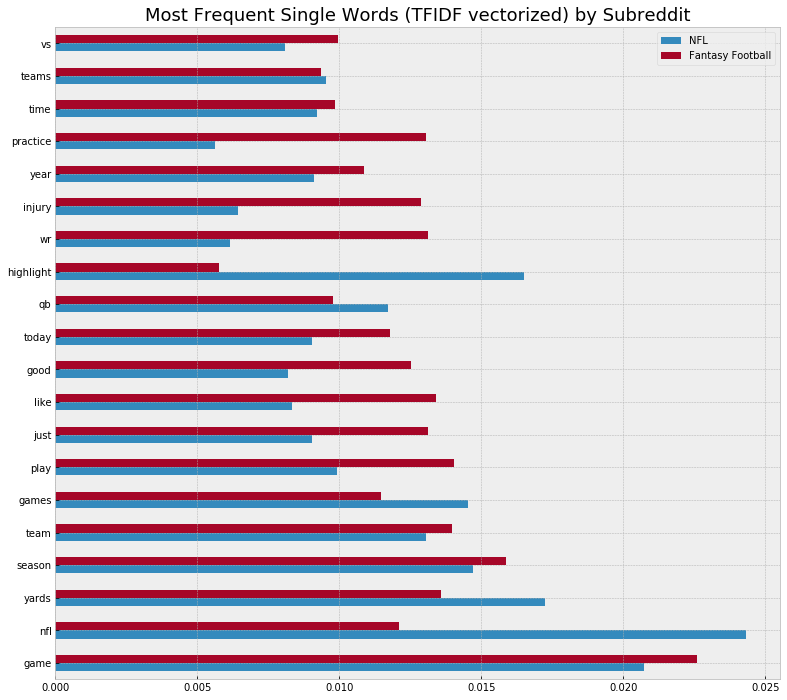

In [168]:
# TFIDF Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
tfidf_df.groupby('pred_target').mean()[tf_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Single Words (TFIDF vectorized) by Subreddit", fontsize = 18);

### Bigram

In [91]:
# Fit the transformer.
bi_tvec = TfidfVectorizer(stop_words=custom_stop, max_df = 0.90, min_df=1, ngram_range=(2,2))

In [92]:
btfidf_df = pd.DataFrame(bi_tvec.fit_transform(df['all_text']).toarray(),
                  columns=bi_tvec.get_feature_names())
btfidf_df.head()

,00 00,00 13,00 50,00 57,00 75,00 86,00 atl,00 bonus,00 bye,00 dst,...,zuerlein 10,zuerlein 30,zuerlein josh,zuerlein kick,zuerlein kicker,zuerlein major,zuerlein obvs,zuerlein owners,zuerlein rams,zuerlein stat
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
btfidf_df['pred_target'] = y

In [94]:
# Let's use dictionary comprehension to create a dictionary of summed words
bfreq_dict2 = {word: btfidf_df[word].sum() for word in bi_tvec.get_feature_names()}

In [95]:
# Create a dataframe with index = 'counts'
bfreq_df2 = pd.DataFrame(bfreq_dict2, index=['counts'])

# Transpose the dataframe
bfreq_df2 = bfreq_df2.T

In [96]:
# Look at the head of the dataframe
btf_top_20 = list(bfreq_df2.sort_values(by='counts', ascending=False).head(20).index)

['baker mayfield',
 'waiver wire',
 'davante adams',
 'sam darnold',
 'david johnson',
 'tyreek hill',
 'amari cooper',
 'practice today',
 'jalen ramsey',
 'todd gurley',
 'monday night',
 'josh gordon',
 'passer rating',
 'patrick mahomes',
 'kyler murray',
 'christian mccaffrey',
 'injury report',
 'deshaun watson',
 'field goal',
 'russell wilson']

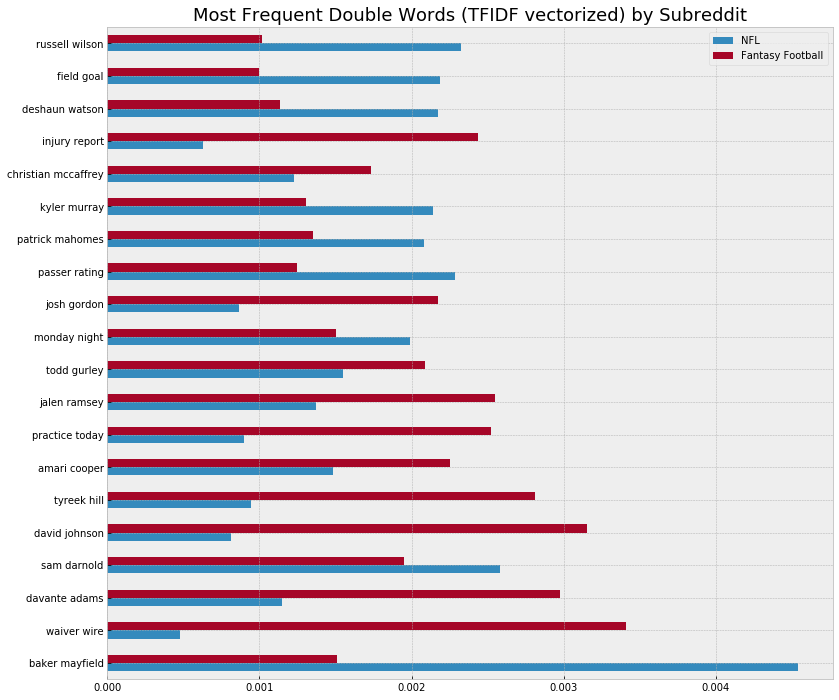

In [169]:
# TFIDF Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
btfidf_df.groupby('pred_target').mean()[btf_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Double Words (TFIDF vectorized) by Subreddit", fontsize = 18);

### Trigram

In [98]:
# Fit the transformer.
tri_tvec = TfidfVectorizer(stop_words=custom_stop, max_df = 0.90, min_df=1, ngram_range=(3,3))

In [99]:
ttfidf_df = pd.DataFrame(tri_tvec.fit_transform(df['all_text']).toarray(),
                  columns=tri_tvec.get_feature_names())
ttfidf_df.head()

,00 00 throw,00 13 54,00 50 50,00 57 29,00 75 75,00 86 18,00 atl falcons,00 bonus twigs,00 bye 25,00 dst new,...,zuerlein 10 rams,zuerlein 30 yard,zuerlein josh lambo,zuerlein kick good,zuerlein kicker matter,zuerlein major outlier,zuerlein obvs hit,zuerlein owners feel,zuerlein rams falcons,zuerlein stat correction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
ttfidf_df['pred_target'] = y

In [101]:
# Let's use dictionary comprehension to create a dictionary of summed words
tfreq_dict2 = {word: ttfidf_df[word].sum() for word in tri_tvec.get_feature_names()}

In [102]:
# Create a dataframe with index = 'counts'
tfreq_df2 = pd.DataFrame(tfreq_dict2, index=['counts'])

# Transpose the dataframe
tfreq_df2 = tfreq_df2.T

In [103]:
# Look at the head of the dataframe
ttf_top_20 = list(tfreq_df2.sort_values(by='counts', ascending=False).head(20).index)

['kick good drive',
 'field goal drive',
 'yd field goal',
 'pro football reference',
 'good drive plays',
 'wr davante adams',
 'wr cb matchups',
 'draft_pos 5b 5d',
 'monday night football',
 'football waiver wire',
 'waiver wire adds',
 'green bay packers',
 'los angeles rams',
 'new england patriots',
 'yds lng tds',
 'tab auto refresh',
 'packers wr davante',
 'mindful rules guidelines',
 'just want regards',
 'players teams just']

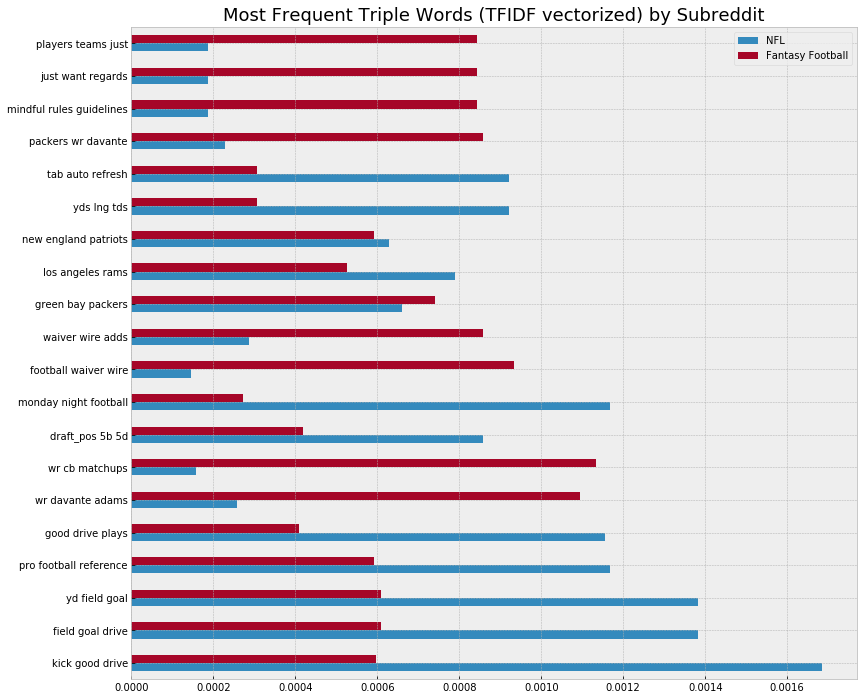

In [170]:
# TFIDF Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
ttfidf_df.groupby('pred_target').mean()[ttf_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Triple Words (TFIDF vectorized) by Subreddit", fontsize = 18);

## Sentiment Filtering

In [107]:
neg_sent_mask = df['sentiment'] < .5
pos_sent_mask = df['sentiment'] > -.5

In [108]:
neg_df = df[neg_sent_mask]
pos_df = df[pos_sent_mask]

### Neg Bigram

In [109]:
# Fit the transformer.
nbi_tvec = TfidfVectorizer(stop_words=custom_stop, max_df = 0.30, min_df=1, ngram_range=(2,2))

In [110]:
nbtfidf_df = pd.DataFrame(nbi_tvec.fit_transform(neg_df['all_text']).toarray(),
                  columns=nbi_tvec.get_feature_names())
nbtfidf_df.head()

,00 espn,00 mcnabb,00 pm,00 redskins,00 ve,000 bought,000 calling,000 mustaches,000 nfl,000 pointsper,...,zone woof,zoo admission,zrebiec earl,zrebiec harbaugh,zuerlein 10,zuerlein 30,zuerlein kicker,zuerlein obvs,zuerlein owners,zuerlein stat
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
nbtfidf_df['pred_target'] = y

In [112]:
# Let's use dictionary comprehension to create a dictionary of summed words
nbfreq_dict2 = {word: nbtfidf_df[word].sum() for word in nbi_tvec.get_feature_names()}

In [113]:
# Create a dataframe with index = 'counts'
nbfreq_df2 = pd.DataFrame(nbfreq_dict2, index=['counts'])

# Transpose the dataframe
nbfreq_df2 = nbfreq_df2.T

In [114]:
# Look at the head of the dataframe
nbtf_top_20 = list(nbfreq_df2.sort_values(by='counts', ascending=False).head(20).index)

['baker mayfield',
 'davante adams',
 'amari cooper',
 'waiver wire',
 'sam darnold',
 'practice today',
 'jalen ramsey',
 'josh gordon',
 'tyreek hill',
 'todd gurley',
 'monday night',
 'injury report',
 'david johnson',
 'patrick mahomes',
 'christian mccaffrey',
 'alvin kamara',
 'kyler murray',
 'deshaun watson',
 'russell wilson',
 'locker room']

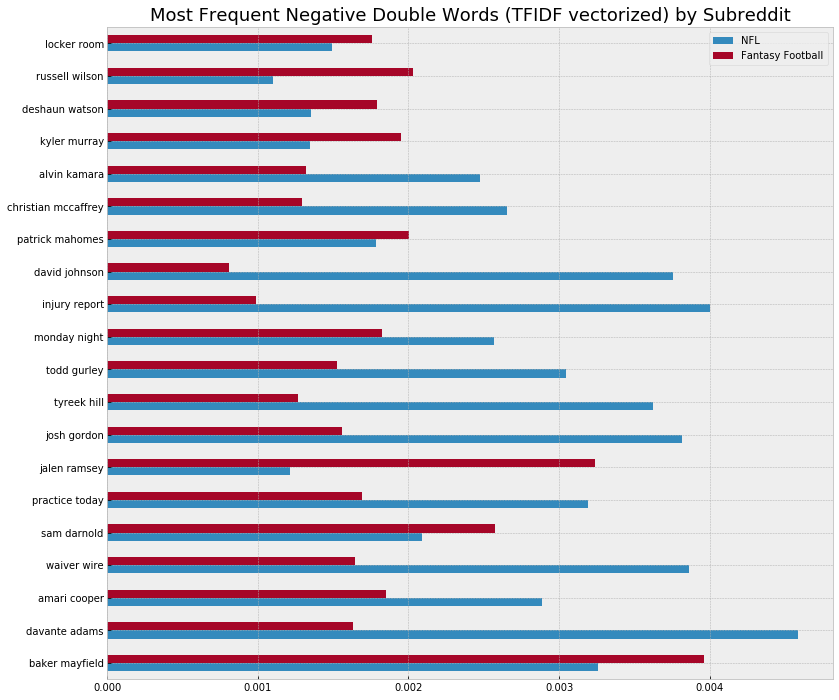

In [171]:
# TFIDF Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
nbtfidf_df.groupby('pred_target').mean()[nbtf_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Negative Double Words (TFIDF vectorized) by Subreddit", fontsize = 18);

### Pos Bigram

In [116]:
# Fit the transformer.
pbi_tvec = TfidfVectorizer(stop_words=custom_stop, max_df = 0.30, min_df=1, ngram_range=(2,2))

In [117]:
pbtfidf_df = pd.DataFrame(pbi_tvec.fit_transform(pos_df['all_text']).toarray(),
                  columns=pbi_tvec.get_feature_names())
pbtfidf_df.head()

,00 00,00 13,00 50,00 57,00 75,00 86,00 atl,00 bonus,00 bye,00 dst,...,zuerlein 10,zuerlein 30,zuerlein josh,zuerlein kick,zuerlein kicker,zuerlein major,zuerlein obvs,zuerlein owners,zuerlein rams,zuerlein stat
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
pbtfidf_df['pred_target'] = y

In [119]:
# Let's use dictionary comprehension to create a dictionary of summed words
pbfreq_dict2 = {word: pbtfidf_df[word].sum() for word in pbi_tvec.get_feature_names()}

In [120]:
# Create a dataframe with index = 'counts'
pbfreq_df2 = pd.DataFrame(pbfreq_dict2, index=['counts'])

# Transpose the dataframe
pbfreq_df2 = pbfreq_df2.T

In [121]:
# Look at the head of the dataframe
pbtf_top_20 = list(pbfreq_df2.sort_values(by='counts', ascending=False).head(20).index)

['baker mayfield',
 'waiver wire',
 'sam darnold',
 'david johnson',
 'davante adams',
 'jalen ramsey',
 'todd gurley',
 'practice today',
 'tyreek hill',
 'patrick mahomes',
 'amari cooper',
 'passer rating',
 'monday night',
 'deshaun watson',
 'kyler murray',
 'christian mccaffrey',
 'russell wilson',
 'field goal',
 'josh gordon',
 'aaron rodgers']

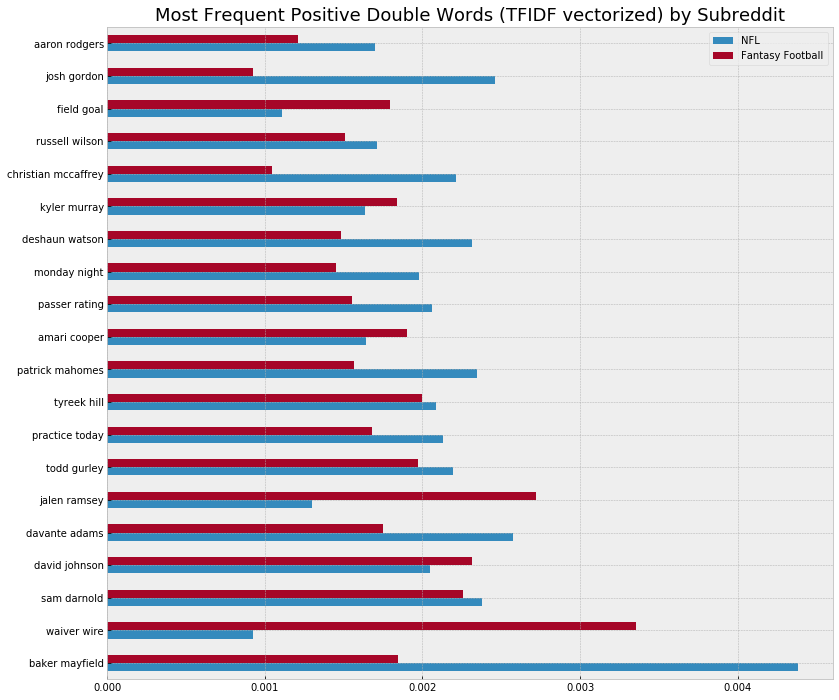

In [172]:
# TFIDF Vectorizer Bar Chart
fig, ax = plt.subplots(figsize=(13,12))
pbtfidf_df.groupby('pred_target').mean()[pbtf_top_20].T.plot.barh(ax=ax)
ax.legend(["NFL", "Fantasy Football"]);
plt.title("Most Frequent Positive Double Words (TFIDF vectorized) by Subreddit", fontsize = 18);

In [173]:
df.head(2)

,title,body,num_comments,upvote_ratio,url,elapsed_time,subreddit,url_website,all_text,text_in_body,word_count,char_count,pred_target,sentiment
0,"Week 6 Overperformers: Robby Anderson, Hunter ...",,36,0.78,https://www.thefantasyfootballadvice.com/artic...,113.369934,r/fantasyfootball,Other,"Week 6 Overperformers: Robby Anderson, Hunter ...",0,9,61,1,0.0
1,Fantasy Football Week 7: Starts & Sits,,8,0.88,https://www.youtube.com/watch?v=bBNYQpk4ziQ,129.536600,r/fantasyfootball,YouTube,Fantasy Football Week 7: Starts & Sits,0,7,38,1,0.0


### Export DataFrame

Exporting DataFrame to csv for notebook 3 to model.

In [125]:
df.to_csv('../data/model_data.csv', index=False)